In [7]:
import sys
import ROOT
import numpy as np
import pandas as pd
import root_pandas
import seaborn as sb
import matplotlib.pyplot as plt
import uproot
import time

from itertools import product

#from root_numpy import root2array

from keras.models import Sequential
from keras.layers import Dense

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.preprocessing import QuantileTransformer
import pickle

In [8]:
################################################
### READ THE CSV FILES CONTAINING THE EVENTS ###
################################################

mu_events = pd.read_csv('mu_events_NOCUT.csv')
tau_events = pd.read_csv('tau_events_NOCUT.csv')
bkg_events = pd.read_csv('bkg_events_NOCUT.csv')

mu_CUT = pd.read_csv('mu_events_CUT.csv')
tau_CUT = pd.read_csv('tau_events_CUT.csv')
bkg_CUT = pd.read_csv('bkg_events_CUT.csv')

# drop the events corresponding to those that we will evaluate our NN on
# we do it because they are few and we want to avoid training in the same dataset on which we will evaluate
mu_events = mu_events.drop(mu_CUT['tree_index'], axis=0)
tau_events = tau_events.drop(tau_CUT['tree_index'], axis=0)
bkg_events = bkg_events.drop(bkg_CUT['tree_index'], axis=0)

In [9]:
#########################################
### PREPARE DFs FOR TRAINING AND TEST ###
#########################################


features = [
    'm2_miss', #missing mass square (p_B - p_mu1 - p_mu2 - p_mu)^2
    'muE_Brf', #mu energy in the Bc rest frame
    'q2', #squared 4momentum transfer to lepton sys (p_B - p_mu1 - p_mu2)^2
    'pT_miss', #missing transverse momentum (p_B - p_mu1 - p_mu2 - p_mu).Pt
    'muE_muSysRf', # unpaired muon energy in the rest frame of the jpsi muons sys
    'pT_var', # difference between the jpsi muons pT
    'jpsi_mass_diffReco', # mu_sys.Mag() - jpsi_mass
    'deltaR_mu1mu2', # deltaR between the two muon reconstructing the jpsi
    'mu_pt',
    'mu_eta',
    'mu_phi',
    'mu1_pt',
    'mu1_eta',
    'mu1_phi',
    'mu2_pt',
    'mu2_eta',
    'mu2_phi'
]

# concatenate the two samples
dataset = pd.concat([mu_events, tau_events, bkg_events],sort=False)

# shuffle and split train/test
train, test = train_test_split(dataset, test_size=0.85, random_state=1986, shuffle=True)

# X and Y on the training sample
X = pd.DataFrame(train, columns=features)
Y = pd.DataFrame(train, columns=['target_bkgNN'])

In [10]:
##################
### PREPROCESS ###
##################


qt = QuantileTransformer(output_distribution='normal', random_state=1986)
qt.fit(X[features])
transformedX = pd.DataFrame(qt.transform(X[features]),columns=features)
pickle.dump( qt, open( 'quantile_tranformation_sgn_bkgNN.pck', 'w' ) )

In [11]:
########################
### DEFINE THE MODEL ###
########################

# model defined and fitted with parameters set with BAYESIAN OPTIMIZATION

# define the model
model = Sequential()
for i in range(4):
    model.add(Dense(128, input_dim=len(features),activation='relu'))
model.add(Dense(1,activation='sigmoid'))

# compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [12]:
#######################
### TRAIN THE MODEL ###
#######################


# fit the model
model.fit(transformedX, Y, epochs=20, batch_size=100, validation_split=0.5)

Train on 85860 samples, validate on 85860 samples
Epoch 1/20
85860/85860 [==============================] - 3s 30us/step - loss: 0.1373 - acc: 0.9422 - val_loss: 0.0996 - val_acc: 0.9587
Epoch 2/20
85860/85860 [==============================] - 2s 26us/step - loss: 0.0931 - acc: 0.9603 - val_loss: 0.0831 - val_acc: 0.9647
Epoch 3/20
85860/85860 [==============================] - 2s 26us/step - loss: 0.0796 - acc: 0.9666 - val_loss: 0.0915 - val_acc: 0.9613
Epoch 4/20
85860/85860 [==============================] - 2s 26us/step - loss: 0.0703 - acc: 0.9704 - val_loss: 0.0726 - val_acc: 0.9699
Epoch 5/20
85860/85860 [==============================] - 2s 28us/step - loss: 0.0627 - acc: 0.9740 - val_loss: 0.0709 - val_acc: 0.9712
Epoch 6/20
85860/85860 [==============================] - 2s 26us/step - loss: 0.0572 - acc: 0.9765 - val_loss: 0.0619 - val_acc: 0.9746
Epoch 7/20
85860/85860 [==============================] - 2s 25us/step - loss: 0.0536 - acc: 0.9778 - val_loss: 0.0606 - val_acc

In [13]:
######################################
### TEST THE TRAINING OF THE MODEL ###
######################################


# evaluate the model
scores = model.evaluate(transformedX, Y)
print("\n%s: %.2f%%" % (model.metrics_names[0], scores[0]*100))
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

# calculate predictions on the test sample
print 'predicting on', test.shape[0], 'events'
x = pd.DataFrame(test, columns=features)
qt = pickle.load(open( 'quantile_tranformation_sgn_bkgNN.pck', 'r' ))
transformedx = qt.transform(x[features])
y = model.predict(transformedx)

# add the score to the test sample dataframe
test.insert(len(test.columns), 'nn_score', y)

171720/171720 [==============================] - 4s 20us/step

loss: 3.94%
acc: 98.48%
predicting on 973081 events


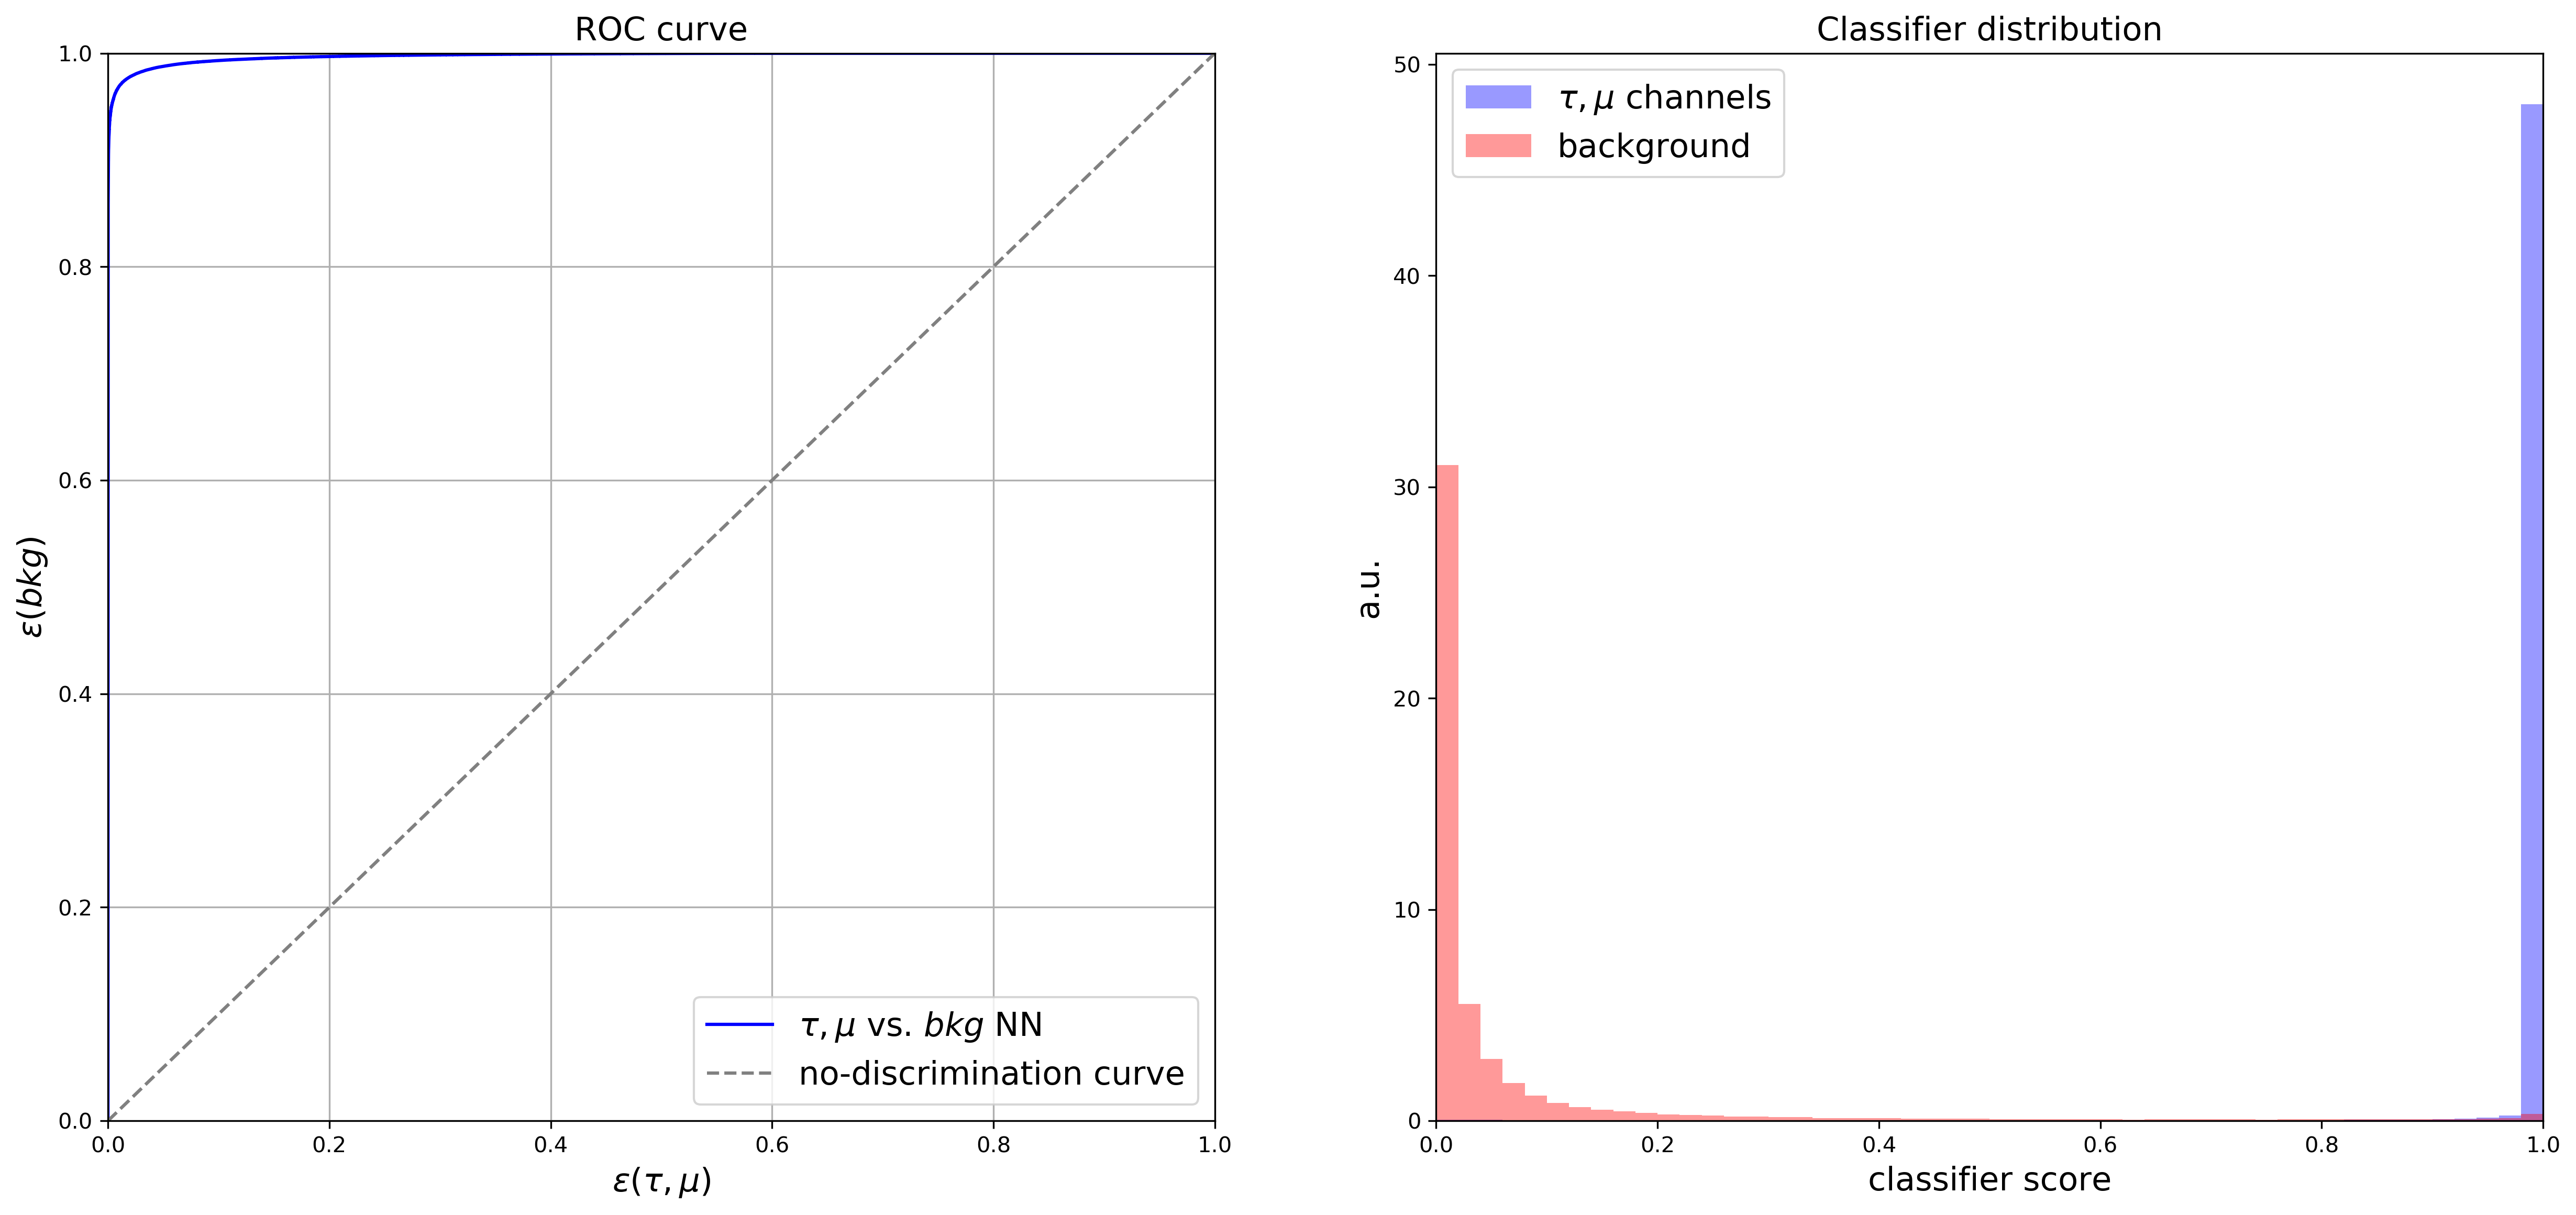

In [14]:
##########################
### ROC & SCORE CURVES ###
##########################


# let sklearn do the heavy lifting and compute the ROC curves for you
fpr, tpr, wps = roc_curve(test.target_bkgNN, test.nn_score)

fig = plt.figure(dpi=300)
fig.set_size_inches(20,9)
ax = fig.add_subplot(121)
# plot
plt.plot(fpr, tpr, label=r'$\tau,\mu$ vs. $bkg$ NN', color='b')
# plot also the diagonal, that corresponds to random picks, no discrimination power
xy = [i*j for i,j in product([10.**i for i in range(-8, 0)], [1,2,4,8])]+[1]
plt.plot(xy, xy, color='grey', linestyle='--', label='no-discrimination curve')
# cosmetics
ax.set_title('ROC curve', fontsize=15)
ax.set_xlabel(r'$\epsilon(\tau,\mu)$', fontsize=15)
ax.set_ylabel(r'$\epsilon(bkg)$', fontsize=15)
# axis range
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
# grid
plt.grid(True)
# legend
plt.legend(loc='best', fontsize=15)
# save figure and then clean it
plt.savefig('sgn_bkg_roc.pdf')
#plt.show()
#plt.clf()
ax = fig.add_subplot(122)
# plot the discriminator shape for the muon and tau channel
test_sgn = test[test.target_bkgNN==1]
test_bkg  = test[test.target_bkgNN==0]
sb.distplot(test_sgn['nn_score'], kde=False, norm_hist=True, label=r'$\tau,\mu$ channels', color='b')
sb.distplot(test_bkg['nn_score'], kde=False, norm_hist=True, label=r'background' , color='r')
ax.set_title('Classifier distribution', fontsize=15)
ax.set_xlabel('classifier score', fontsize=15)
ax.set_ylabel('a.u.', fontsize=15)
plt.xlim([0.0, 1.0])
plt.legend(loc='best', fontsize=15)
plt.savefig('sgn_bkg_score.pdf')
#plt.show()
#plt.clf()

In [15]:
# compute the auc
auroc = auc(fpr, tpr)
print "AUC =", auroc 

# compute Gini index
print "Gini index =", (auroc-0.5)*2

sgn = test[test.nn_score>0.8]
sgn = sgn[sgn.target_bkgNN>0]
norm = test[test.target_bkgNN>0]
print 'Efficiency of signal discrimination from background =', float(sgn['nn_score'].count())/float(norm['nn_score'].count())

sgn = test[test.nn_score>0.8]
sgn = sgn[sgn.target_bkgNN>0]
norm = test[test.nn_score>0.8]
print 'Purity of signal discrimination from background =', float(sgn['nn_score'].count())/float(norm['nn_score'].count())

AUC = 0.9973994981781743
Gini index = 0.9947989963563486
Efficiency of signal discrimination from background = 0.978866489948
Purity of signal discrimination from background = 0.995586434622


predicting on 3169 events
AUC = 0.98704
Gini index = 0.9740800000000001
Efficiency of signal discrimination from background = 0.99104
Purity of signal discrimination from background = 0.99549983928


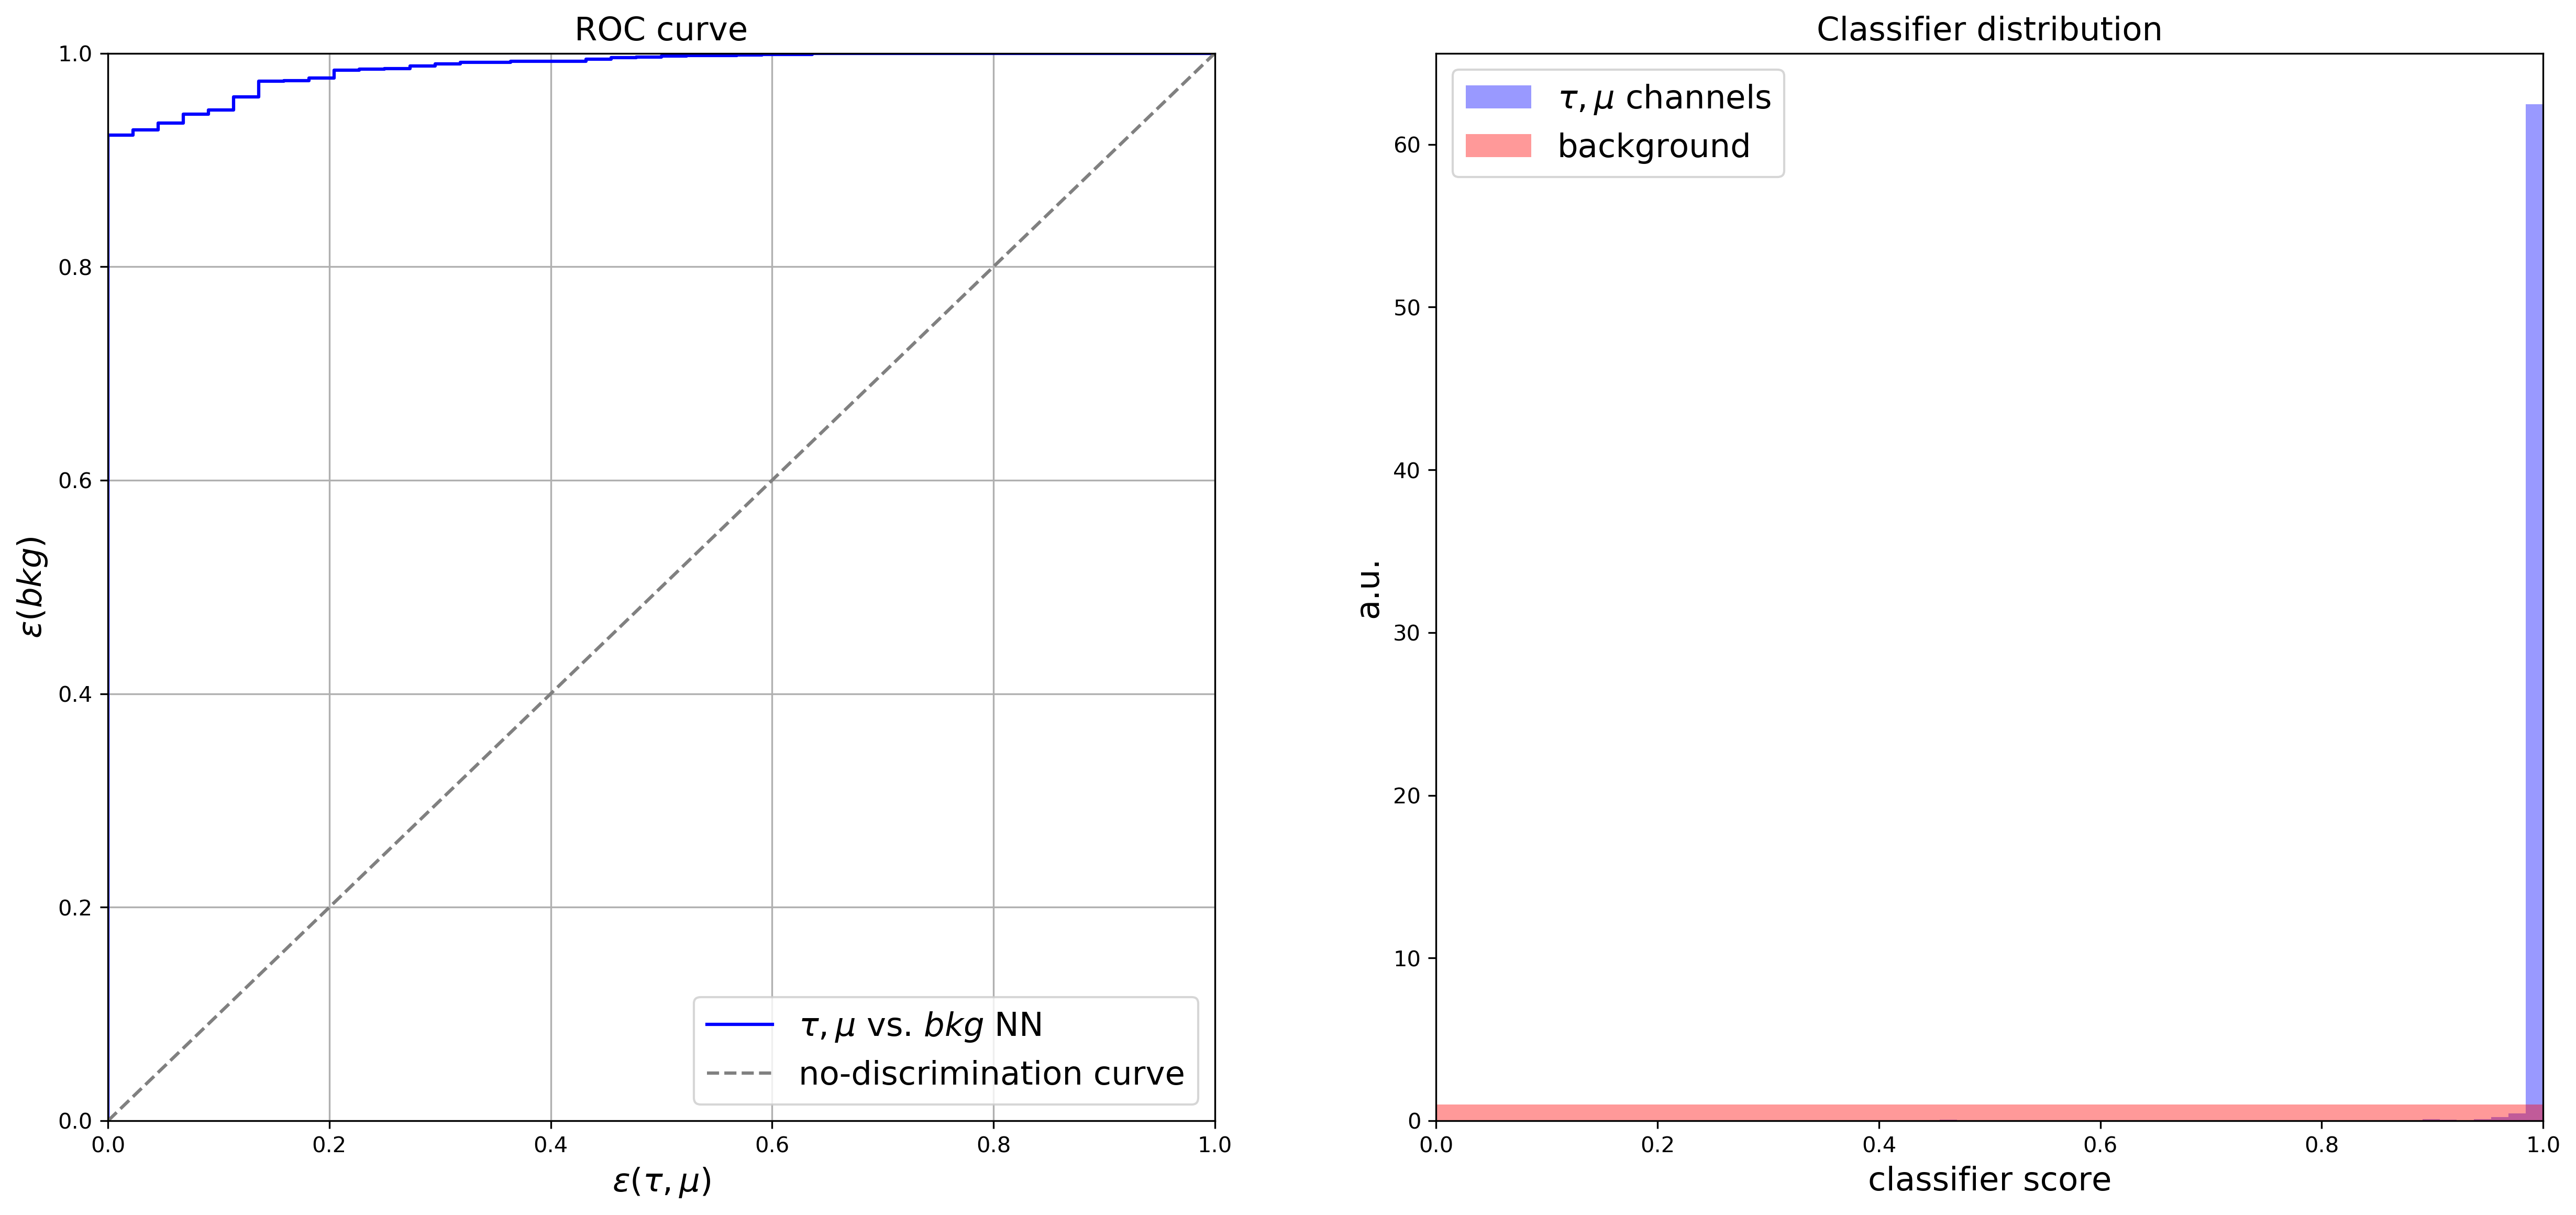

In [16]:
###########################################################
### EVALUATE THE MODEL ON THE DATA THAT PASSED THE CUTS ###
###########################################################


data = pd.concat([mu_CUT, tau_CUT, bkg_CUT],sort=False)

# calculate predictions on the data sample
print 'predicting on', data.shape[0], 'events'
x = pd.DataFrame(data, columns=features)
qt = pickle.load(open( 'quantile_tranformation_sgn_bkgNN.pck', 'r' ))
transformedx = qt.transform(x[features])
y = model.predict(transformedx)

# add the score to the data sample dataframe
data.insert(len(data.columns), 'bkgNN_score', y)

# let sklearn do the heavy lifting and compute the ROC curves for you
fpr, tpr, wps = roc_curve(data.target_bkgNN, data.bkgNN_score)

fig = plt.figure(dpi=300)
fig.set_size_inches(20,9)
ax = fig.add_subplot(121)
# plot
plt.plot(fpr, tpr, label=r'$\tau,\mu$ vs. $bkg$ NN', color='b')
# plot also the diagonal, that corresponds to random picks, no discrimination power
xy = [i*j for i,j in product([10.**i for i in range(-8, 0)], [1,2,4,8])]+[1]
plt.plot(xy, xy, color='grey', linestyle='--', label='no-discrimination curve')
# cosmetics
ax.set_title('ROC curve', fontsize=15)
ax.set_xlabel(r'$\epsilon(\tau,\mu)$', fontsize=15)
ax.set_ylabel(r'$\epsilon(bkg)$', fontsize=15)
# axis range
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
# grid
plt.grid(True)
# legend
plt.legend(loc='best', fontsize=15)
# save figure and then clean it
plt.savefig('sgn_bkg_roc.pdf')
#plt.show()
#plt.clf()
ax = fig.add_subplot(122)
# plot the discriminator shape for the muon and tau channel
data_sgn = data[data.target_bkgNN==1]
data_bkg  = data[data.target_bkgNN==0]
sb.distplot(data_sgn['bkgNN_score'], kde=False, norm_hist=True, label=r'$\tau,\mu$ channels', color='b')
sb.distplot(data_bkg['bkgNN_score'], kde=False, norm_hist=True, label=r'background' , color='r')
ax.set_title('Classifier distribution', fontsize=15)
ax.set_xlabel('classifier score', fontsize=15)
ax.set_ylabel('a.u.', fontsize=15)
plt.xlim([0.0, 1.0])
plt.legend(loc='best', fontsize=15)
plt.savefig('sgn_bkg_score.pdf')
#plt.show()
#plt.clf()

# compute the auc
auroc = auc(fpr, tpr)
print "AUC =", auroc 

# compute Gini index
print "Gini index =", (auroc-0.5)*2

sgn = data[data.bkgNN_score>0.8]
sgn = sgn[sgn.target_bkgNN>0]
norm = data[data.target_bkgNN>0]
print 'Efficiency of signal discrimination from background =', float(sgn['bkgNN_score'].count())/float(norm['bkgNN_score'].count())

sgn = data[data.bkgNN_score>0.8]
sgn = sgn[sgn.target_bkgNN>0]
norm = data[data.bkgNN_score>0.8]
print 'Purity of signal discrimination from background =', float(sgn['bkgNN_score'].count())/float(norm['bkgNN_score'].count())

In [17]:
mu_channel = pd.read_csv('mu_channel_CUT.csv')
tau_channel = pd.read_csv('tau_channel_CUT.csv')
bkg_channel = pd.read_csv('bkg_channel_CUT.csv')

# i tau
temp = data[data['target_sgnNN']==1]
temp = temp[temp['target_bkgNN']==1]
temp = temp['bkgNN_score']
tau_channel = tau_channel.join(temp)

# i mu
temp = data[data['target_sgnNN']==0]
temp = temp[temp['target_bkgNN']==1]
temp = temp['bkgNN_score']
mu_channel = mu_channel.join(temp)

# il bkg
temp = data[data['target_sgnNN']==0]
temp = temp[temp['target_bkgNN']==0]
temp = temp['bkgNN_score']
bkg_channel = bkg_channel.join(temp)

mu_channel = mu_channel.drop(['Unnamed: 0','Unnamed: 0.1'], axis=1)
tau_channel = tau_channel.drop(['Unnamed: 0','Unnamed: 0.1'], axis=1)
bkg_channel = bkg_channel.drop(['Unnamed: 0','Unnamed: 0.1'], axis=1)

mu_channel.to_csv('mu_channel_CUT.csv')
tau_channel.to_csv('tau_channel_CUT.csv')
bkg_channel.to_csv('bkg_channel_CUT.csv')